In [1]:
from torchvision.models import vgg16
import os 
from PIL import Image  # Image Load
import numpy as np
from matplotlib import pyplot #to show image
import xml.etree.ElementTree as ET # to get bndbox
import torch
from torch import nn
import torchvision # .opt.nms
import torch.nn.functional as F # softmax
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tarfile

tar = tarfile.open("drive/MyDrive/voctar")
tar.extractall()
tar.close()

In [5]:
from torchvision.io import read_image

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.img_dir = os.path.join(data_dir, 'JPEGImages')
    self.anno_dir = os.path.join(data_dir, 'Annotations')
    self.ids = self.get_ids(self.img_dir)
    self.class_dict, self.class_names = self.get_dataset_info()
    self.transform = transform
    self.normalize = torchvision.transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    )
  def get_ids(self, img_dir):
    ids = []
    for file_name in os.listdir(img_dir):
      ids.append(file_name.split('.')[0])
    ids.sort()
    return ids

  def get_dataset_info(self):
    class_dict = {'background':0, }
    class_names = ['background', ] ### zeroth index is for background
    class_idx = 1
    for id in self.ids:
      anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
      for obj in anno.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_dict:
          class_dict[class_name] = class_idx
          class_idx += 1
          class_names.append(class_name)
    return class_dict, class_names

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, i):
    if i >= len(self.ids): print("ERROR, size exceeded")
  
   
    id = self.ids[i]
    img_file = os.path.join(self.img_dir, id + '.jpg')
    image = Image.open(img_file)
    image = np.transpose(image, (2, 0, 1))
    img_bndboxes = []
    img_classes = []

    #image = image.float()
    
    image = image / 256.
    image = torch.tensor(image, device=dev)#
    x = self.normalize(image)

    anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
    for obj in anno.findall('object'):
      class_name = obj.find('name').text
      img_classes.append(self.class_dict[class_name])
      
      bndbox = obj.find('bndbox')
      img_bndboxes.append(
          [float(bndbox.find(tag).text) - 1 for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
      )
    
    #print(image.shape)
    #x = torch.tensor(image, device=dev)#
    #print(X.shape)
    hh, ww = x.size(1), x.size(2)
    g_box = torch.tensor(img_bndboxes)
    g_cls = torch.tensor(img_classes)
    g_box[:, (0, 2)] /= ww
    g_box[:, (1, 3)] /= hh
    if self.transform:
      x = self.transform(x)
    
    sample = {"X":x, "G_box":g_box, "G_cls":g_cls}

    return sample
  
  def get_image(self, i):
    id = self.ids[i]
    img_file = os.path.join(self.img_dir, id + '.jpg')
    image = Image.open(img_file)
    return image


In [6]:
imageDataset = ImageDataset('VOCdevkit/VOC2007', torchvision.transforms.Resize((416, 416)))

In [ ]:
imageDataset.class_names

['background',
 'chair',
 'car',
 'horse',
 'person',
 'bicycle',
 'cat',
 'dog',
 'train',
 'aeroplane',
 'diningtable',
 'tvmonitor',
 'bird',
 'bottle',
 'motorbike',
 'pottedplant',
 'boat',
 'sofa',
 'sheep',
 'cow',
 'bus']

In [7]:
eval_ratio = 0.2
eval_len = int(len(imageDataset) * eval_ratio)
def no_random_split(ds, lengths):
  indices = range(sum(lengths))
  lengths_acc = [l + lengths[i-1] if i != 0 else l for i, l in enumerate(lengths)]
  return [torch.utils.data.Subset(ds, indices[offset - length : offset]) for offset, length in zip(lengths_acc, lengths)]

#train_ds, eval_ds = torch.utils.data.random_split(imageDataset, [len(imageDataset) - eval_len, eval_len])
train_ds, eval_ds = no_random_split(imageDataset, [len(imageDataset) - eval_len, eval_len])

# DataLoader

In [8]:
def batch_collate(batch_data):
  X = []
  G_imgidx, G_box, G_cls = [], [], []
  for i in range(len(batch_data)):
    ith_batch_data = batch_data[i]
    x, g_box, g_cls = ith_batch_data['X'], ith_batch_data['G_box'], ith_batch_data['G_cls']
    X.append(x)
    G_imgidx.append(torch.tensor([i]*len(g_box)))
    G_box.append(g_box)
    G_cls.append(g_cls)
  X = torch.stack(X, dim=0).to(dev)
  G_imgidx = torch.cat(G_imgidx, dim=0).to(dev)
  G_box = torch.cat(G_box, dim=0).to(dev)
  G_cls = torch.cat(G_cls, dim=0).to(dev)
  G = (G_imgidx, G_box, G_cls)
  return X, G

In [9]:
train_dl = DataLoader(train_ds, batch_size=2, shuffle=False, collate_fn = batch_collate) #num_workers=1)



# Model
---input:X, output:H (Y_pred)


In [10]:
#input : 448*448
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, input):
        return self.func(input)

darknet = nn.Sequential(
  nn.Conv2d(3, 64, 7, stride=2, padding=3),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(64, 192, 3, padding=1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(192, 128, 1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(128, 256, 3, padding=1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 256, 1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True), 
  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 512, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(1024, 512, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 512, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, stride=2, padding=1), nn.LeakyReLU(0.1, inplace=True),

  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  Lambda(lambda x: x.view(-1, 1024*7*7)),
  #7*7*1024
  nn.Linear(7*7*1024, 4096), nn.LeakyReLU(0.1, inplace=True),
  nn.Dropout(p=0.5),
  nn.Linear(4096, 7*7*30),
  Lambda(lambda x: x.view(-1, 7, 7, 30)),
)

In [ ]:
class SSD(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = torchvision.models.vgg16().features

  def forward(self, X):
    return self.vgg(X)

ssd = SSD()
ssd(next(iter(train_dl))[0]).shape

RuntimeError: ignored

In [11]:
def get_y_center(S):
  print(np.linspace(0, 1, num=S, endpoint=False))
  _y_center = np.linspace(0, 1, num=S, endpoint=False) + (1/S)*0.5
  _y_center_x = _y_center[None, :] + np.zeros(S)[:, None]
  _y_center_y = _y_center[:, None] + np.zeros(S)[None, :]

  y_center = np.stack((_y_center_x, _y_center_y), axis=2)
  y_center= np.reshape(y_center, (-1, 2))
  y_center = torch.from_numpy(y_center).to(dev)
  return y_center
y_center = get_y_center(S=13)

[0.         0.07692308 0.15384615 0.23076923 0.30769231 0.38461538
 0.46153846 0.53846154 0.61538462 0.69230769 0.76923077 0.84615385
 0.92307692]


In [12]:
def get_anchor(B):
  assert B==5, 'B should be 5'
  anchor = [[0.1, 0.1],\
            [0.2, 0.2],\
            [0.3, 0.3],\
            [0.5, 0.5],\
            [0.7, 0.7]]
  return torch.tensor(anchor).to(dev)
A_wh = get_anchor(5)

def get_anchor_full(y_center, A_wh):
  '''y_center : (S*S, 2), A_wh: (B, 2)'''
  _A = torch.cat((y_center[:, None, :] - A_wh[None, :, :]/2, y_center[:, None, :] + A_wh[None, :, :]/2), dim=2)
  A = _A.reshape(-1, 4)
  return A
A = get_anchor_full(y_center, A_wh)

In [13]:
class Darknet(nn.Module):
  def __init__(self, darknet, C=20, S=13, B=5):
    super().__init__()
    self.darknet = darknet
    self.convnet = nn.Conv2d(512, B*(C+4), 3, stride=1, padding=1)
    #self.convnet = convnet
    self.params = C, S, B
    
  def forward(self, X):
    C, S, B = self.params

    N = len(X)
    X.to(dev)

    _H = self.darknet(X.float())
    H = self.convnet(_H).permute(0, 2, 3, 1)
    H_cls = H[:, :, :, :B*C].clone()
    H_box = H[:, :, :, B*C:B*C + B*4].clone()
      
    H_cls = H_cls.reshape(N, -1, C)  
    H_cls = F.log_softmax(H_cls, dim=-1)
    
    H_box = H_box.view(N, -1, B, 4)
    H_box[:, :, :, 0:2] = 2*torch.sigmoid(H_box[:, :, :, 0:2]) - 0.5 + y_center[None, :, None, :] # N S*S B 4
    H_box[:, :, :, 2:4] = A_wh[None, None, :, :] * torch.exp(H_box[:, :, :, 2:4]) # N S*S B- 2-
    print(H_box.shape)
    H_box = H_box.reshape(N, -1, 4)
    print(H_box.shape)
    return (H_box, H_cls) # which is Y_pred

In [40]:
vgg16 = torchvision.models.vgg16_bn(pretrained=True)
darknet = nn.Sequential(
  vgg16.features,                     
  #nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #downsample by 32.
)
darknet_model = Darknet(darknet).to(dev)

# Loss

In [15]:
def sum_sq_error(X, mask):
  loss = torch.pow(X, 2) * mask
  return torch.sum(loss)

In [16]:
def get_iou(h_box, y_box):
  #-iou-#
  #print(h_box.device, y_box.device)
  tl = torch.maximum(h_box[:, :, :2], y_box[:, None, :2]) # 49 2 2
  br = torch.minimum(h_box[:, :, 2:], y_box[:, None, 2:])

  iou_inter = torch.all(tl < br, axis=-1) * torch.prod(br-tl, axis=-1) # 49 2
  iou_a = torch.prod(h_box[:, :,  2:] - h_box[:, :, :2], axis=-1) # 49 2
  iou_b = torch.prod(y_box[:, 2:] - y_box[:, :2], axis=-1, keepdim=True) # 49 1
  iou = iou_inter / (iou_a + iou_b - iou_inter) # 49 2

  return iou

In [17]:
#TO BE MODIFIED
def get_iou_from_A(A, g_box):
  '''g_box: (n_G, 4), A: full anchor (S*S*k_i, 4)'''
  print(A.shape, g_box.shape, A.device)
  tl = torch.maximum(A[:, None, :2], g_box[None, :, :2])
  br = torch.minimum(A[:, None, 2:], g_box[None, :, 2:]) # n_G, S*S*k_i, 2

  iou_inter = torch.all(tl < br, axis=-1) * torch.prod(br-tl, axis=-1) # n_G, S*S*k_i
  iou_a = torch.prod(A[:, 2:] - A[:, :2], axis=-1) # n_G
  iou_b = torch.prod(g_box[:, 2:] - g_box[:, :2], axis=-1) # S*S*k_i
  iou = iou_inter / (iou_a[:, None] + iou_b[None, :] - iou_inter) #

  return iou

In [ ]:
print(A)

tensor([[-0.0115, -0.0115,  0.0885,  0.0885],
        [-0.0615, -0.0615,  0.1385,  0.1385],
        [-0.1115, -0.1115,  0.1885,  0.1885],
        ...,
        [ 0.8115,  0.8115,  1.1115,  1.1115],
        [ 0.7115,  0.7115,  1.2115,  1.2115],
        [ 0.6115,  0.6115,  1.3115,  1.3115]], device='cuda:0',
       dtype=torch.float64)


In [18]:
### G -> Y
import math
def repack_Y(G, A, H):
  G_imgidx, G_box, G_cls = G
  H_box, H_cls = H

  N = H_box.size(0)
  S2B = H_box.size(1)
  C = H_cls.size(2)
  #S = int(math.sqrt(S2))

  G_center = torch.stack(((G_box[:, 0] + G_box[:, 2])/2,
                              (G_box[:, 1] + G_box[:, 3])/2), axis=1).to(dev)
  G_wh = torch.stack(((G_box[:, 2] - G_box[:, 0]),
                          G_box[:, 3] - G_box[:, 1]), axis=1).to(dev)
  _G_box = torch.stack((G_center, G_wh), axis=1).view(-1, 4)
  
  Y_box = torch.zeros((N, S2B, 4)).to(dev)
  Y_cls = torch.zeros((N, S2B)).long().to(dev)
  Y_obj = torch.zeros((N, S2B)).to(dev)

  for i in range(N):

    ith_batch_idx = (G_imgidx == i).nonzero(as_tuple=True)[0]
    g_box = G_box[ith_batch_idx] # 4c scheme
    _g_box = _G_box[ith_batch_idx] # wh scheme
    g_cls = G_cls[ith_batch_idx]
    h_box = H_box[i]

    #print(F.one_hot(max_iou_idx(h_box, Y_box[i]), num_classes=2).shape)

    iou = get_iou_from_A(A, g_box)
    #let's assume for now, iou : [A, n_G]
    max_iou = torch.max(iou, axis=-1)[0]
    print("max", torch.max(max_iou))
    max_iou_idx = torch.argmax(iou, axis=-1)
    #print('hi'+max_iou.shape)
    Y_box[i] = _g_box[max_iou_idx, :]
    Y_cls[i] = g_cls[max_iou_idx]
    Y_obj[i] = (max_iou >= 0.4)
  return (Y_box, Y_cls, Y_obj) # which is Y

In [19]:
def get_loss(Y_pred, Y, l_noobj=0.1, l_coord=5):
  H_box, H_cls = Y_pred
  Y_box, Y_cls, Y_obj = Y
  C = H_cls.size(2) #N S*S*k C
  
  Y_cls[Y_obj == 0] = 0
  print(Y_obj.sum())
  weight_tensor = torch.ones(C).to(dev)
  weight_tensor[0] = l_noobj

  L_cls = F.nll_loss(H_cls.reshape(-1, C), Y_cls.reshape(-1), reduction='sum', weight=weight_tensor)
  
  L_box1 = sum_sq_error(H_box[:, :, 0] - Y_box[:, :, 0], Y_obj)
  L_box2 = sum_sq_error(H_box[:, :, 1] - Y_box[:, :, 1], Y_obj)
  L_box3 = sum_sq_error(torch.sqrt(H_box[:, :, 2]) - torch.sqrt(Y_box[:, :, 2]), Y_obj)
  L_box4 = sum_sq_error(torch.sqrt(H_box[:, :, 3]) - torch.sqrt(Y_box[:, :, 3]), Y_obj)

  L_box = L_box1 + L_box2 + L_box3 + L_box4
  L = L_cls + l_coord * L_box
  print(f' LOSS: {L.item()}, {L_cls.item()}, {L_box.item()}')

  '''
  l1 = l_coord * sum_sq_error(H_box[:, :, :, 0] - Y_box[:, :, None, 0], Y_obj_ij)
  l2 = l_coord * sum_sq_error(H_box[:, :, :, 1] - Y_box[:, :, None, 1], Y_obj_ij)
  l3= l_coord * sum_sq_error(torch.sqrt(H_box[:, :, :, 2]) \
    - torch.sqrt(Y_box[:, :, None, 2]), Y_obj_ij)
  l4= l_coord * sum_sq_error(torch.sqrt(H_box[:, :, :, 3]) \
    - torch.sqrt(Y_box[:, :, None, 3]), Y_obj_ij)
  l5=  sum_sq_error(H_conf - Y_conf, Y_obj_ij == 1)
  l6=  l_noobj * sum_sq_error(H_conf - Y_conf, Y_obj_ij == 0)
  l7=  sum_sq_error(H_cls - F.one_hot(Y_cls, num_classes=C), Y_obj[:, :, None])
  L = l1 + l2 + l3 + l4 + l5 + l6 + l7
  #print(H_conf, H_cls)
  print(f'  LOSS: , {L.item()}, {l1.item()}, {l2}, {l3}, {l4}, {l5}, {l6}, {l7.item()}')
  '''
  return L

# Train/Eval

In [41]:
optimizer = torch.optim.Adam(
    darknet_model.parameters(), lr=0.0001, #weight_decay = 0.0005 #this caused error
)

In [21]:
n_epochs=5
l_coord=5
l_noobj=0.1

In [45]:
def train(n_epochs, model, train_dl, opt):
  model.train()
  for epoch_idx in range(n_epochs):
    for batch_idx, data in enumerate(train_dl):
      X, G = data
      opt.zero_grad()
      Y_pred = model(X.float())
      Y = repack_Y(G, A, Y_pred)
      L = get_loss(Y_pred, Y, l_noobj=0.1, l_coord=5)
      L.backward()

      #nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
      opt.step()
      break
train(20, darknet_model, train_dl, optimizer)

torch.Size([2, 169, 5, 4])
torch.Size([2, 845, 4])
torch.Size([845, 4]) torch.Size([5, 4]) cuda:0
max tensor(0.6344, device='cuda:0', dtype=torch.float64)
torch.Size([845, 4]) torch.Size([1, 4]) cuda:0
max tensor(0.7994, device='cuda:0', dtype=torch.float64)
tensor(67., device='cuda:0')
 LOSS: 189.0188751220703, 180.0458526611328, 0.1794605553150177
torch.Size([2, 169, 5, 4])
torch.Size([2, 845, 4])
torch.Size([845, 4]) torch.Size([5, 4]) cuda:0
max tensor(0.6344, device='cuda:0', dtype=torch.float64)
torch.Size([845, 4]) torch.Size([1, 4]) cuda:0
max tensor(0.7994, device='cuda:0', dtype=torch.float64)
tensor(67., device='cuda:0')
 LOSS: 174.60000610351562, 165.9424591064453, 0.1731509566307068
torch.Size([2, 169, 5, 4])
torch.Size([2, 845, 4])
torch.Size([845, 4]) torch.Size([5, 4]) cuda:0
max tensor(0.6344, device='cuda:0', dtype=torch.float64)
torch.Size([845, 4]) torch.Size([1, 4]) cuda:0
max tensor(0.7994, device='cuda:0', dtype=torch.float64)
tensor(67., device='cuda:0')
 LOSS: 

In [ ]:
a = torch.tensor([1, 2, 3])
idx = torch.tensor([0, 0, 0, 0])
b = a[idx]
print(b)

tensor([1, 1, 1, 1])


In [ ]:
#https://github.com/rafaelpadilla/Object-Detection-Metrics
def get_mAP(Y_pred, G):
  

In [ ]:
def save_GT():
  pass
def save_predictions(Y_pred, batch_idx):
  H_conf, H_box = Y_pred
  for i in range(len(H_conf)):
    save('batch_idx*10000+i.txt', H_conf[i], H_box[i])

In [ ]:
def eval(n_epochs, model, eval_dl, l_coord=5, l_noobj=0.1):
  model.eval()
  for batch_idx, data in enumerate(train_dl):
    X, G = data

    Y_pred = model(X.float())
    Y = repack_Y(G, Y_pred)
    L = get_loss(l_coord, l_noobj, Y_pred, Y)

    save_predictions(Y_pred) # save H_conf, H_box information
  mAP = get_mAP(Y_pred_file, G_file)
  


In [ ]:
eval(5, darknet_model, eval_dl)

NameError: ignored

# Predict

In [23]:
def wh_to_4c(t_box):
  #tensor box wh scheme to xy scheme
  
  _t_box = torch.cat((t_box[..., :2] - t_box[..., 2:]/2, t_box[..., :2] + t_box[..., 2:]/2), dim=-1)
  return _t_box

In [46]:
#needs refinement (nasty)
def predict(model, i, conf_lb=0.5, print_ground=False):
  data = imageDataset[i]
  X, G_box, G_cls = data["X"], data["G_box"], data["G_cls"]
  X = X[None, :]
  #G_box = G_box[None, :]
  #G_cls = G_cls[None, :]
  X, G_box, G_cls = X.to(dev), G_box.to(dev), G_cls.to(dev)
  

  model.eval()
  with torch.no_grad():  
    H_box, H_cls = model(X.float())
    #print(G_box.shape)
    G = (torch.zeros(G_box.size(0)).to(dev), G_box, G_cls) 
    Y_pred = model(X.float())

    
    Y = repack_Y(G, A, Y_pred)
    print(Y[2].sum())

    S2B = H_box.size(1)
    C = H_cls.size(2)
    #print(H_box.shape)
    _H_box = H_box.reshape(S2B, 4)
    _H_cls = H_cls.reshape(S2B, C)
    _H_conf = _H_cls.max(dim=-1)[0]
    _H_cls_argmax = _H_cls.argmax(dim=-1)
    #print(torch.exp(_H_conf))
    print(_H_cls_argmax)
    _H_obj = torch.logical_and((_H_cls_argmax != 0), (torch.exp(_H_conf) > conf_lb))
    #print(_H_obj)
    H_box_sltd = _H_box[_H_obj]
    H_cls_sltd = _H_cls[_H_obj]
    H_cls_argmax_sltd = _H_cls_argmax[_H_obj]
    H_conf_sltd = torch.exp(_H_conf[_H_obj])

    #print(Y)
    #print(len(H_box_sltd))
    print(H_conf_sltd)
    print(wh_to_4c(H_box_sltd))
    pred_boxes_indices = torchvision.ops.batched_nms(boxes=wh_to_4c(H_box_sltd).float(), 
                                                     scores=H_conf_sltd, idxs=H_cls_argmax_sltd, iou_threshold=0.7)
    print(len(pred_boxes_indices))
    Y_pred_boxes = H_box_sltd[pred_boxes_indices]
    Y_pred_cls = H_cls_sltd[pred_boxes_indices]
    Y_pred_conf = H_conf_sltd[pred_boxes_indices]

    image = np.array(imageDataset.get_image(i))
    hh = image.shape[0]
    ww = image.shape[1]
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    fig = plt.figure(i)
    #print(X[1].shape)
    plt.imshow(image)
    
    #plt.plot(y_center[:, 0].cpu().numpy()*ww, y_center[:, 1].cpu().numpy()*hh, 'o')
    if print_ground:
      #Y_box, Y_cls, Y_obj, Y_obj_ij, Y_conf = get_Y_data(G_imgidx, G_box, G_cls, H_box)
      Y_boxes = G_box.view(-1, 4)
      Y_cls = G_cls.view(-1)
      for j in range(len(Y_boxes)):
        g_box = Y_boxes[j]
        xx = g_box[0] * ww
        xy = g_box[1] * hh
        yx = g_box[2] * ww
        yy = g_box[3] * hh
        w = yx-xx
        h = yy-xy
        plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='b',facecolor='none'))
      
    for j in range(len(Y_pred_boxes)):
      pred_box = Y_pred_boxes[j]
      xc = pred_box[0] * ww
      yc = pred_box[1] * hh
      w = pred_box[2] * ww
      h = pred_box[3] * hh
      xx = xc - w/2
      xy = yc - h/2
      ##print(xx, xy, w, h)
      print(xc.data, yc.data, w.data, h.data)
      plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r',facecolor='none'))


torch.Size([1, 169, 5, 4])
torch.Size([1, 845, 4])
torch.Size([1, 169, 5, 4])
torch.Size([1, 845, 4])
torch.Size([845, 4]) torch.Size([5, 4]) cuda:0
max tensor(0.6344, device='cuda:0', dtype=torch.float64)
tensor(12., device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

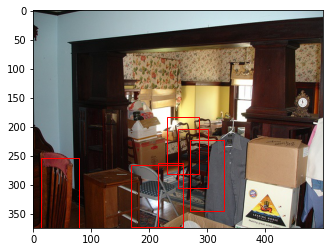

In [47]:
predict(model=darknet_model, i=0, conf_lb=0.5, print_ground=False)